<a href="https://colab.research.google.com/github/anaiy2004/African-American-Police-Killings-Classifier/blob/master/PoliceKillingsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Download and Pre-Processing from [Mapping Police Violence]("https://static1.squarespace.com/static/54ecf211e4b0ed744420c5b6/t/5f04cebda843400a2e8bacd4/1594150600757/MPVDatasetDownload.xlsx")





In [ ]:
#installing useful libraries
!pip install xlrd   
!pip install psycopg2

In [ ]:
#importing useful libraries
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import psycopg2 as ps

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
#url of download
url = "https://static1.squarespace.com/static/54ecf211e4b0ed744420c5b6/t/5f31d7baf701ba6b241e8b2b/1597102011823/MPVDatasetDownload.xlsx"

In [ ]:
#creates a dataframe by reading in url with columns = column_names
column_names = ["Victims name" ,  "VictimsAge" , "VictimsGender" , "VictimsRace", "URL of image" , "Date of Incident", "Street" , "City" , "State" , "Zipcode" , "County" , "Agency", "Strange", "CauseOfDeath" , "description" , "disposition" , "CriminalCharges" , "link" , "MentalIllness" , "Armed" , "AllegedWeapon" , "AllegedThreatLevel" , "Fleeing" , "BodyCam", "WaPO ID"  , "Offduty" , "Geo" , "ID"]
df  = pd.read_excel(url, "2013-2020 Police Killings", header=None, names = column_names)
df = df.iloc[1:]
df.head()

,Victims name,VictimsAge,VictimsGender,VictimsRace,URL of image,Date of Incident,Street,City,State,Zipcode,County,Agency,Strange,CauseOfDeath,description,disposition,CriminalCharges,link,MentalIllness,Armed,AllegedWeapon,AllegedThreatLevel,Fleeing,BodyCam,WaPO ID,Offduty,Geo,ID
1,Kevin Lee Catlett,62,Male,Unknown race,NaN,2020-06-30 00:00:00,900 McArthur Street,Johnson City,TN,37601,Washington,Johnson City Department,TN0900100,Gunshot,"About 7 p.m., Johnson City police were respond...",Pending investigation,No known charges,https://wcyb.com/news/local/officer-involved-s...,Drug or alcohol use,Allegedly Armed,gun,attack,NaN,NaN,NaN,NaN,NaN,NaN
2,Nick Costales,34,Male,Hispanic,https://fatalencounters.org/wp-content/uploads...,2020-06-29 00:00:00,9501 Monte Vista Ave,Montclair,CA,91763,San Bernardino,"Pomona Police Department, California Highway P...",CA0195500;CA0349900,Gunshot,Nick Costales was wanted for murdering his mot...,Pending investigation,No known charges,https://kmph.com/news/local/fresno-murder-susp...,No,Allegedly Armed,gun,attack,NaN,NaN,NaN,NaN,NaN,NaN
3,Wade Russell Meisberger,48,Male,White,https://fatalencounters.org/wp-content/uploads...,2020-06-29 00:00:00,West Beech St and South Church St,Hazleton,PA,18201,Luzerne,"Pennsylvania State Police, U.S. Marshals Service",PAPSPAB00;US Marshals,Gunshot,Wade Russell Meisberger was the passenger insi...,Pending investigation,No known charges,https://www.pahomepage.com/top-stories/police-...,No,Allegedly Armed,gun,attack,Car,No,5958,NaN,NaN,NaN
4,Brittany S. Teichroeb,26,Female,White,NaN,2020-06-29 00:00:00,TX-191 and TX-250 Loop,Midland,TX,79706,Midland,"Texas Department of Public Safety, U.S. Marsha...",TX0000000;US Marshals,Gunshot,Troopers were assisting U.S. deputy marshals i...,Pending investigation,No known charges,https://www.yourbasin.com/news/local-news/deta...,No,Allegedly Armed,gun,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,John Parks,57,Male,White,https://fatalencounters.org/wp-content/uploads...,2020-06-29 00:00:00,Court Avenue and Audubon Drive,Paducah,KY,42001,McCracken,McCracken County Sheriff's Office,KY0730000,Gunshot,"John Parks, 57, was shot and killed just befor...",Pending investigation,No known charges,https://www.kentucky.com/news/local/crime/arti...,No,Unclear,undetermined,undetermined,Car,No,5953,NaN,NaN,NaN


In [ ]:
#deleting unnecesary information
df = df.drop(columns=['Victims name' , 'Strange', 'City', 'URL of image', 'County' , "AllegedThreatLevel", 'Street', 'Date of Incident' , "Offduty", 'Zipcode' , 'Agency' , 'description' , 'disposition' , 'link' , 'WaPO ID' , 'Geo' , 'ID' ])


In [ ]:
#deleting unclear data and null values
df = df[df.VictimsRace != "Unknown Race"]
df = df[df.MentalIllness != "Unknown"]
df = df[df.AllegedWeapon != "unclear"]
df = df[df.AllegedWeapon != "unknown weapon"]
df = df[df.AllegedWeapon != "undetermined"]
df = df[df.Fleeing != "Other"]
df = df.dropna()
df.head()

,VictimsAge,VictimsGender,VictimsRace,State,CauseOfDeath,CriminalCharges,MentalIllness,Armed,AllegedWeapon,Fleeing,BodyCam
3,48,Male,White,PA,Gunshot,No known charges,No,Allegedly Armed,gun,Car,No
6,68,Male,White,OH,Gunshot,No known charges,Yes,Allegedly Armed,gun,Not fleeing,No
12,30,Male,White,NV,Gunshot,No known charges,Drug or alcohol use,Allegedly Armed,gun,Foot,No
13,38,Male,White,IN,Gunshot,No known charges,No,Allegedly Armed,gun,Car,No
17,27,Male,White,FL,Gunshot,No known charges,No,Allegedly Armed,gun,Not fleeing,No


In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#creates a one-hot encoder function which returns a column of our dataframe one-hot encodeded as well as their categorical name (given input of the column) 

def one_hot_encode(data):
  values = array(data)
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(values)
  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
  shape = onehot_encoded.shape
  inverted = []
  for i in range(shape[-1]):
      inverted.append(label_encoder.inverse_transform([i]))
  return onehot_encoded, inverted



In [ ]:
# declares output array
outputs = [[] for i in range(len(df))] 

In [ ]:
#creates inputs [1,0] = African American Killing by Police, [0,1] = non African American Killing by Police
races = df["VictimsRace"] 
count = 0
for race in races:
  if(race == "Black"):
    outputs[count].append(1)
    outputs[count].append(0)
  else:
    outputs[count].append(0)
    outputs[count].append(1)
  count += 1
df = df.drop(columns = "VictimsRace")

In [ ]:
df = df.drop(columns="VictimsAge")
df.head()
#shows the input dataframe before it is one-hot encoded

,VictimsGender,State,CauseOfDeath,CriminalCharges,MentalIllness,Armed,AllegedWeapon,Fleeing,BodyCam
3,Male,PA,Gunshot,No known charges,No,Allegedly Armed,gun,Car,No
6,Male,OH,Gunshot,No known charges,Yes,Allegedly Armed,gun,Not fleeing,No
12,Male,NV,Gunshot,No known charges,Drug or alcohol use,Allegedly Armed,gun,Foot,No
13,Male,IN,Gunshot,No known charges,No,Allegedly Armed,gun,Car,No
17,Male,FL,Gunshot,No known charges,No,Allegedly Armed,gun,Not fleeing,No


In [ ]:
# creates inputs by one-hot encoding individual dataframe columns
# inverted is a list of categorical data which corresponds to each "1" in the one-hot encoding
inputs = list()
inverted = []
for column in df:
  check = array((df[column]))
  encodedArray = one_hot_encode(check)[0]
  inverted.extend(one_hot_encode(check)[1])
  inputs.append(encodedArray)
inputs = np.hstack(inputs)


In [ ]:
# creates a train/test split of 80-20
outputs = np.array(outputs)
split = int(0.8*len(inputs))
X_train, X_test, y_train, y_test = inputs[:split], inputs[split:], outputs[:split], outputs[split:]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
# creates a MLP that serves as a Linear Regression with an activation function
model = Sequential()
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics=["accuracy"])


In [ ]:
# fits the model to the training data
# it is extremely important to use class_weights as otherwise, the model only predicts one class (as  around 75% of the inputs are non-African American Killings)
# this ensures that our model is fair and treats the individual accuracy of each class' classification the same
class_weight = {0: 2.5,
                1: 1
                }
model.fit(X_train, y_train,
            batch_size=32,
            epochs=40,
            validation_split = 0.2,
             shuffle = True, class_weight = class_weight)
model.summary()

Epoch 1/40
81/81 [==============================] - 0s 3ms/step - loss: 0.9942 - accuracy: 0.4441 - val_loss: 0.6843 - val_accuracy: 0.5730
Epoch 2/40
81/81 [==============================] - 0s 2ms/step - loss: 0.9516 - accuracy: 0.6166 - val_loss: 0.6344 - val_accuracy: 0.7127
Epoch 3/40
81/81 [==============================] - 0s 2ms/step - loss: 0.9321 - accuracy: 0.7242 - val_loss: 0.6389 - val_accuracy: 0.7050
Epoch 4/40
81/81 [==============================] - 0s 2ms/step - loss: 0.9154 - accuracy: 0.7156 - val_loss: 0.6184 - val_accuracy: 0.7314
Epoch 5/40
81/81 [==============================] - 0s 2ms/step - loss: 0.9018 - accuracy: 0.7152 - val_loss: 0.6079 - val_accuracy: 0.7267
Epoch 6/40
81/81 [==============================] - 0s 2ms/step - loss: 0.8912 - accuracy: 0.7110 - val_loss: 0.5972 - val_accuracy: 0.7360
Epoch 7/40
81/81 [==============================] - 0s 2ms/step - loss: 0.8825 - accuracy: 0.7094 - val_loss: 0.5876 - val_accuracy: 0.7345
Epoch 8/40
81/81 [==

In [ ]:
preds = model.predict(X_test)
check = 0
num_correct = 0
for i in range(len(preds)):
  if (np.argmax(preds[i]) == np.argmax(y_test[i])):
    num_correct += 1  
print("The fraction of correctly classified examples in the test set is: " + str(num_correct / len(preds)))

The fraction of correctly classified examples in the test set is: 0.7167701863354037


In [ ]:
for layerNum, layer in enumerate(model.layers):
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
    bias0 = biases[0]
    bias1 = biases[1]
    for toNeuronNum, bias in enumerate(biases):
        print(f'{layerNum}B -> L{layerNum+1}N{toNeuronNum}: {bias}')
    
    for fromNeuronNum, wgt in enumerate(weights):
        for toNeuronNum, wgt2 in enumerate(wgt):
            print(f'L{layerNum}N{fromNeuronNum} \
                  -> L{layerNum+1}N{toNeuronNum} = {wgt2}')
            

0B -> L1N0: -0.040609076619148254
0B -> L1N1: 0.040609102696180344
L0N0                   -> L1N0 = -0.034971415996551514
L0N0                   -> L1N1 = 0.19061653316020966
L0N1                   -> L1N0 = 0.11833985894918442
L0N1                   -> L1N1 = -0.11699873954057693
L0N2                   -> L1N0 = 0.3320845663547516
L0N2                   -> L1N1 = -0.10252849012613297
L0N3                   -> L1N0 = -0.02777741849422455
L0N3                   -> L1N1 = 0.07161396741867065
L0N4                   -> L1N0 = -0.271052747964859
L0N4                   -> L1N1 = 0.2539598345756531
L0N5                   -> L1N0 = 0.11436846107244492
L0N5                   -> L1N1 = -0.25553444027900696
L0N6                   -> L1N0 = 0.0959700271487236
L0N6                   -> L1N1 = -0.2426925152540207
L0N7                   -> L1N0 = -0.6967018246650696
L0N7                   -> L1N1 = 0.6218882203102112
L0N8                   -> L1N0 = -0.2990719974040985
L0N8                   -> L1N1 

In [ ]:
def softmax(x):
  exponentials = np.exp(x)
  sum_exponentials = sum(exponentials)
  result = exponentials/sum_exponentials
  return result


In [ ]:
count = 0
finalweights = [[] for i in range(183)]
for rows in weights:
  input0 = 0
  input1 = 1
  hidden0 = (input0*rows[0])+(input1*rows[0])+(bias0)
  hidden1 = (input0*rows[1])+(input1*rows[1])+(bias1)
  softmaxInputs = []
  softmaxInputs.append(hidden0)
  softmaxInputs.append(hidden1)
  finalweights[count] = array(softmax(softmaxInputs))
  count += 1

In [ ]:
for i in range(len(finalweights)): #set random seed
  print(inverted[i][0] + " " + str(finalweights[i][0]) + " " + str(finalweights[i][1]))

Female 0.42389451749948015 0.5761054825005197
Male 0.5384540180538592 0.46154598194614077
Transgender 0.5874405849860509 0.41255941501394905
Unknown 0.45496994819371234 0.5450300518062876
AK 0.352919490798192 0.6470805092018079
AL 0.5716741006607137 0.42832589933928633
AR 0.5640079561922944 0.4359920438077055
AZ 0.19784654511378966 0.8021534548862104
CA 0.34401825897972704 0.655981741020273
CO 0.23580304268809196 0.764196957311908
CT 0.48614743692347184 0.5138525630765282
DC 0.6624861801608449 0.33751381983915507
DE 0.638210363098497 0.36178963690150306
FL 0.5891481364670839 0.41085186353291625
GA 0.6368196640973329 0.3631803359026671
HI 0.09860212280388173 0.9013978771961182
IA 0.47087329778887993 0.52912670221112
ID 0.2096794287693554 0.7903205712306446
IL 0.6413460245141688 0.3586539754858312
IN 0.5932025468642355 0.40679745313576465
KS 0.3483649246980804 0.6516350753019196
KY 0.29360987566399155 0.7063901243360085
LA 0.7638207766694425 0.23617922333055763
MA 0.29472556163077984 0.7

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth= 3)
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


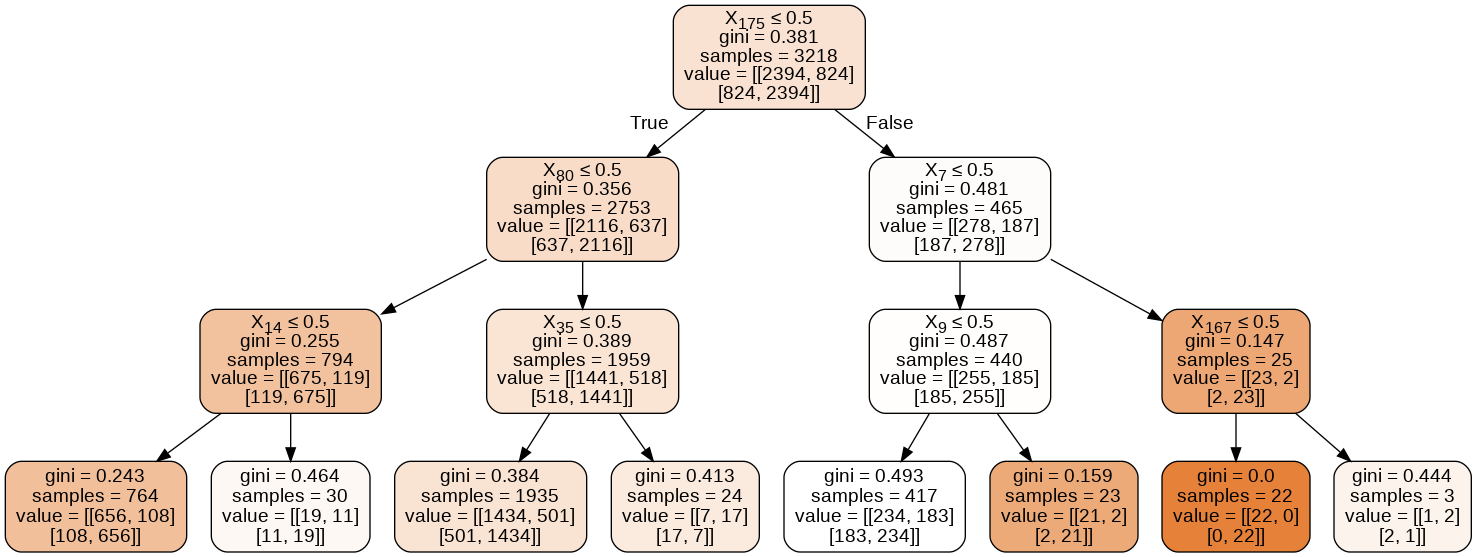

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
preds = model.predict(X_test)
print(preds[0])
cross_val_score(model, X_train, y_train, cv=2)

[0 1]


array([0.75077688, 0.73958981])